# Project : Bahasa Isyarat Indonesia (BISINDO) Classification 3
  
- multiclass classification
- dataset : [link](https://www.kaggle.com/datasets/achmadnoer/alfabet-bisindo)

## Import Libary

In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import zipfile,os
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image 
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D, MaxPooling1D, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import cv2
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import pytz
from datetime import datetime 

# evaluate
from sklearn.metrics import f1_score 
import pathlib

# split  
import pandas as pd
pd.set_option("display.max_columns", 101) 

import splitfolders
from shutil import unpack_archive
from tensorflow.keras.preprocessing import image
from tqdm.notebook import tqdm

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
import itertools

from keras.preprocessing.image import img_to_array

## Utilize
- additional function

### load image

In [3]:
# LOAD IMAGE
def load_image(image_file):
    image_data = cv2.imread(image_file)
    output = cv2.resize(image_data, (512,512))
    return output

### Augmentation Image Utilize

- resize

In [4]:
# RESIZE
def resize_func(image_data, target_dir, index):
    output = cv2.resize(image_data, (256,256))
    cv2.imwrite(os.path.join("%s/img_%05d.jpg"%(target_dir ,index)), output)
    return output

- Brightness

In [5]:
# BRIGHTNESS
def brightness_func(image_data, target_dir, index):
    for i in range(1,41):
        factor = i*2 +70
        enhanced = Image.fromarray(np.uint8(image_data))
        enhanced = ImageEnhance.Brightness(enhanced).enhance(factor/100)
        enhanced = np.asarray(enhanced)
        output = resize_func(enhanced, target_dir, index) 
        index += 1
    return index

- Translate

In [6]:
# TRANSLATE
def translate_func(image_data, target_dir, index):
    position_y = -32
    for i in range(0,33):
        position_x = -32
        for j in range(0,33):
            scale_fit = max(abs(position_x), abs(position_y))
            M = np.float32([[1, 0, position_x], [0, 1, position_y]])
            shifted = cv2.warpAffine(image_data, M, (512, 512))
            shifted = shifted[0+scale_fit:512-scale_fit, 0+scale_fit:512-scale_fit] # Not mandatory
            output = resize_func(shifted, target_dir, index)
            position_x += 2
            index += 1
        position_y += 2
    return index

- zoom

In [7]:
# ZOOM
def zoom_func(image_data, target_dir, index):
    scale_fit = 0
    for i in range(0,20):
        scaled = image_data[0+scale_fit:512-scale_fit, 0+scale_fit:512-scale_fit]
        output = resize_func(scaled, target_dir, index)
        scale_fit += 4
        index += 1
    return index

- Rotate

In [8]:
# ROTATE
def rotate_func(image_data, target_dir, index):
    scale_fit = 32
    for i in range(-10,11):
        M = cv2.getRotationMatrix2D((512/2, 512/2), i, 1.0)
        rotated = cv2.warpAffine(image_data, M, (512, 512))
        rotated = rotated[0+scale_fit:512-scale_fit, 0+scale_fit:512-scale_fit] # Not mandatory
        output = resize_func(rotated, target_dir, index)
        index += 1
    return index

- Prepare folders

## Data Preparation

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
'''
!rm -rf './temp'
!rm -rf './resize'
!rm -rf './brightness'
!rm -rf './translate'
!rm -rf './zoom'
!rm -rf './rotate'
!rm -rf './Data'
'''

"\n!rm -rf './temp'\n!rm -rf './resize'\n!rm -rf './brightness'\n!rm -rf './translate'\n!rm -rf './zoom'\n!rm -rf './rotate'\n!rm -rf './Data'\n"

In [13]:
!rm -rf './dataset'
os.mkdir('./dataset')
os.mkdir('./dataset/alphabets') # The output file will be put here
datasets_dir = "Citra BISINDO"
shutil.unpack_archive('drive/MyDrive/ML/1_Dataset_Bisindo.zip')

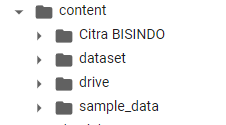

In [14]:
print(sorted(os.listdir(datasets_dir)))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


## Data Preprocessing

### Image Augmentation

1. **cek jumlah dataset sebelum augmentation**

<BarContainer object of 26 artists>

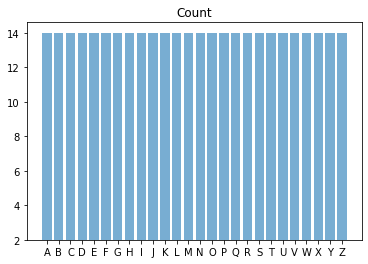

In [15]:
from string import ascii_uppercase

alphabets = [az for az in ascii_uppercase]
counts = [sum(os.path.isfile(os.path.join('./Citra BISINDO/'+az, f)) for f in os.listdir('./Citra BISINDO/'+az)) for az in ascii_uppercase]

plt.title('Count')
plt.bar(alphabets, counts, alpha=0.6, bottom=2, linewidth=2)

- terdapat +- 14x26 = 364

2. Define time 
  - untuk mengukur lama waktu proses augmentasi 

In [16]:
UTC = pytz.utc
timeJKT = pytz.timezone('Asia/Jakarta') 
start_time = datetime.now(timeJKT).replace(microsecond=0)

3. Do augmentation

In [17]:
for label in sorted(os.listdir(datasets_dir)):
    os.mkdir(f'./dataset/alphabets/{label}')
    target_dir = f'./dataset/alphabets/{label}'
    index = 1
    print(label)
    for image_file in sorted(os.listdir(f'{datasets_dir}/{label}')):
        image_dir = f'{datasets_dir}/{label}/{image_file}'
        image_data = load_image(image_dir)
        
        # Use all types of augmentation (the order doesn't matter)
        index = brightness_func(image_data, target_dir, index)
        index = translate_func(image_data, target_dir, index)
        index = zoom_func(image_data, target_dir, index)
        index = rotate_func(image_data, target_dir, index)
        

A
B
C
D
E
F
G
H
I
J
K
L
M
N
O
P
Q
R
S
T
U
V
W
X
Y
Z


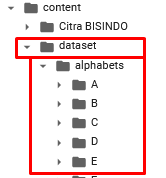

4. **Cek jumlah dataset setelah augmentasi**

In [18]:
print(f'Augmented per raw image: {int((index-1) /12)} images')
print(f'Augmented per alphabet: {index-1} images')
print(f'Total augmented image: {(index-1) *26} images')

Augmented per raw image: 1170 images
Augmented per alphabet: 14040 images
Total augmented image: 365040 images


<BarContainer object of 26 artists>

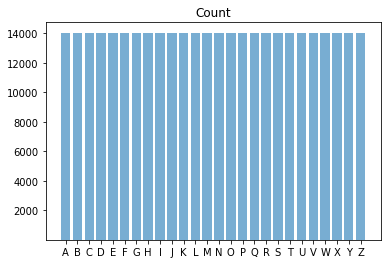

In [19]:
from string import ascii_uppercase

alphabets = [az for az in ascii_uppercase]
counts = [sum(os.path.isfile(os.path.join('./dataset/alphabets/'+az, f)) for f in os.listdir('./dataset/alphabets/'+az)) for az in ascii_uppercase]

plt.title('Count')
plt.bar(alphabets, counts, alpha=0.6, bottom=2, linewidth=2)

- terdapat +- 14.000x26 = 364.000
  - datanya bertambah 1000x lipat dari sebelumnya

5. Show augmentation duration process

In [20]:
end_time = datetime.now(timeJKT).replace(microsecond=0)
print("Start Time    : %s"%start_time)
print("End Time      : %s"%end_time)
print("Total Duration: ",end_time - start_time)
print(f'Augmented per raw image: {int((index-1) /12)} images')
print(f'Augmented per alphabet: {index-1} images')
print(f'Total augmented image: {(index-1) *26} images')

Start Time    : 2022-08-31 13:02:47+07:00
End Time      : 2022-08-31 13:24:51+07:00
Total Duration:  0:22:04
Augmented per raw image: 1170 images
Augmented per alphabet: 14040 images
Total augmented image: 365040 images


- proses augmentation berlangsung selama 25 menit, jika tanpa GPU mungkin bisa mencapai 1 jam 

6. Show examples of images randomly 

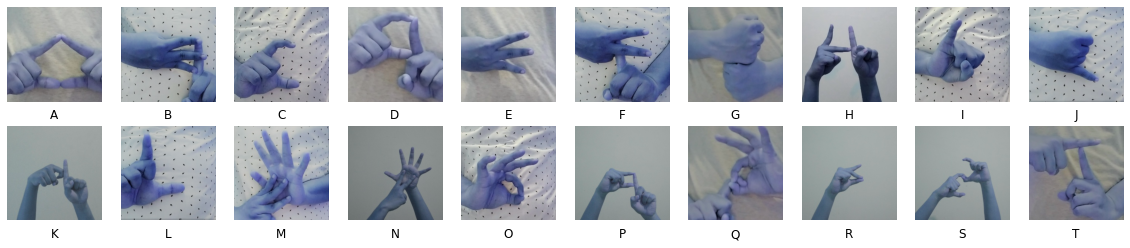

In [21]:
sample_images = []

for folder in sorted(os.listdir('./dataset/alphabets')):
    for image_inside in os.listdir(f'./dataset/alphabets/{folder}'):
        selector = random.randint(1, index-1)
        temp_img = cv2.imread(f'./dataset/alphabets/{folder}/img_{selector:05}.jpg')
        sample_images.append(temp_img)
        break

row = 2
col = 10
fig = plt.figure(figsize = (col*2,row*2))
for load_samples in range(0,row*col):
    fig.add_subplot(row, col, load_samples+1)
    plt.axis('off')
    plt.imshow(sample_images[load_samples])
    label = chr(load_samples+65)
    plt.title(label, y=-0.25)
plt.show()

### Check Point

1. membuat **Checkpoint**
kita simpan dataset kita yg baru dari hasil augmented, untuk digunakan kembali berhubung proses augmentednya lama jika diulang kembali

  - hasil augmentation kita zip untuk cadangan
  - ukuran augmented_alphabets.zip : 5 Gb, jika kapasitas google drive tidak mencukupi abaikan tahap ini

In [ ]:
!zip -r './alphabets_augmented.zip' './dataset/alphabets'
# shutil.make_archive("BISINDO_dataset", 'zip', "./dataset") cara lain

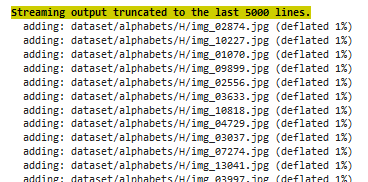

## Data Exploratory

### Jumlah Dataset

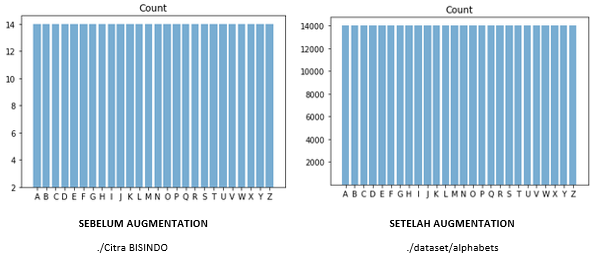

### Ukuran image

In [16]:
tmpImgDir = './dataset/alphabets/A/img_00001.jpg'
img1 = cv2.imread(tmpImgDir, cv2.IMREAD_UNCHANGED)
 
# get dimensions of image
dimensions = img1.shape  

# height, width, number of channels in image
height = img1.shape[0]
width = img1.shape[1]
channels = img1.shape[2]
 
print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)

Image Dimension    :  (256, 256, 3)
Image Height       :  256
Image Width        :  256
Number of Channels :  3


- shape image sebelumnya

In [17]:
tmpImgDir = './Citra BISINDO/A/body dot (1).jpg'
img1 = cv2.imread(tmpImgDir, cv2.IMREAD_UNCHANGED)
 
# get dimensions of image
dimensions = img1.shape  

# height, width, number of channels in image
height = img1.shape[0]
width = img1.shape[1]
channels = img1.shape[2]
 
print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)

Image Dimension    :  (858, 857, 3)
Image Height       :  858
Image Width        :  857
Number of Channels :  3


- ukuran dataset image
  - sebelum augmentation : 858 x 858
  - **setelah augmentation : 256 x 256**

## Data Preprocessing 2

### Split Datasets

1. membuat augmentasi lagi namun hanya untuk mendefiniskan variabel dari directory source data set training dan validation
  - split data source (data dir) into data training and data testing
  - mendefiniskan directory source data set training dan validation
  - data train : data test = 80:20

In [22]:
import pathlib

data_dir1 = '/content/dataset/alphabets'
data_dir = pathlib.Path(data_dir1)

batch_size = 64
img_width = 256
img_height = int(img_width/640*480)
print(img_height)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, #20% data validatiom
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)


192
Found 365040 files belonging to 26 classes.
Using 292032 files for training.
Found 365040 files belonging to 26 classes.
Using 73008 files for validation.


- image_dataset_from_directory VS flow_from_directory [link](https://datascience.stackexchange.com/questions/78405/image-dataset-from-directory-vs-flow-from-directory)

2. mengecek lagi komposisi dataset kita untuk memastikan data terbagi

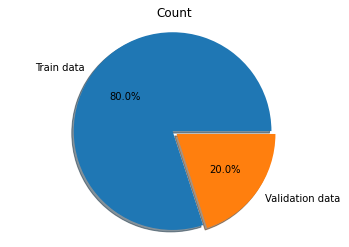

In [18]:
labels = ['Train data', 'Validation data']
values = [len(train_ds), len(val_ds)]

plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, explode=(0, 0.05))
plt.axis('equal')
plt.title('Count')
plt.show()

## Modeling

1. Desing model arsitektur

In [5]:
#Untuk AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

- tidak ada target size di `image_dataset_from_directory`

In [6]:
img_augmentation = Sequential(
    [
        layers.RandomTranslation(height_factor=0.1, width_factor=(0,0.1), input_shape=(img_height, img_width, 3)),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomZoom(-0.2, 0.1),
        layers.RandomContrast(factor=(0.2,0)),
    ],
    name="img_augmentation",
)

In [7]:
def custom_model1():

    classifier = Sequential()

    img_augmentation,
    classifier.add( Rescaling(1./255, input_shape=(img_height, img_width, 3))),

    # 1st CNN Layer
    classifier.add(Conv2D(16, (3, 3), input_shape = (128, 128, 1), activation = 'relu', padding="same"))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))

    # 2nd CNN Layer
    classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding="same"))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))

    # 3rd CNN Layer
    classifier.add(Conv2D(48, (3, 3), activation = 'relu', padding="same"))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))

    # 4th CNN Layer
    classifier.add(Conv2D(64, (3, 3), activation = 'relu', padding="same"))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))

    classifier.add(Flatten())
    
    # 1st Fully Connected Layer
    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dropout(0.5))

    # output layer
    classifier.add(Dense(units = 26, activation = 'softmax'))

    classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    return classifier

In [8]:
model1 = custom_model1()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 192, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 192, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 128, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 128, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 64, 48)        1

2. train model

In [ ]:
history1 = model1.fit(train_ds, 
                         steps_per_epoch=len(train_ds), 
                         epochs = 20,
                         verbose=1,
                         validation_data=val_ds, 
                         validation_steps=len(val_ds),
                         callbacks=[callback]
                         )

Epoch 1/20
 134/4563 [..............................] - ETA: 11:27 - loss: 2.1459 - accuracy: 0.3460

**Training gagal** (Run out of memory)

- karena ukuran gambar terlalu besar diproses serta
- karena keterbatasan ram maka proses training tidak dapat diproses


## Data preprocessing 3

### Image augmentation lagi 
- guna memperkecil size image

- Data dibagi menjadi 3 data training, data validasi dan data testing
  - rasio 6:2:2

1. Define source dan target directory
  - jika belum ada, creating dir..

In [32]:
path = './dataset/alphabets/'
gen_path = 'generate'

if not os.path.isdir(gen_path):
  print('path not exists, creating dir...')
  os.mkdir(gen_path)
else:
  print('path exists...')

path not exists, creating dir...


2. define image generator

In [24]:
# datagen = ImageDataGenerator(rotation_range=15,
#                              zoom_range=0.2,
#                              fill_mode='nearest',
#                              width_shift_range=0.15, 
#                              height_shift_range=0.15,
#                              brightness_range=[0.7,1.3]
#                              )

datagen = ImageDataGenerator(rescale=1./255)

3. implementation image generator ke `image sources('./dataset/alphabets/')` kemudina hasil nya disimpan di `generate directory(./generate/)`

  - berkurangnya jumlah dataset terjadi disini
  - for k in range(50): 
    - set angka 50 ini, semaking tinggi semakin banyak datasetnya tergenerate
      - contoh : 
      - 100 -> 500 dataset/label
      - 50  -> 250 dataset/label

In [33]:
for i in os.listdir(path):
  print(i)
  if not os.path.isdir(gen_path+"/"+i):
    print('path not exists, creating dir...')
    os.mkdir(gen_path+"/"+i)
  else:
    print('path exists...')
  gen = datagen.flow_from_directory(
          path,
          target_size=(256, 256),
          color_mode='rgb',
          classes=[i],
          class_mode='binary',
          batch_size=5,
          shuffle=False,
          seed=1182,
          save_to_dir=gen_path+"/"+i,
          save_prefix='gen',
          save_format='png'
        )
  
  for k in range(50):
    gen.next()

W
path not exists, creating dir...
Found 14040 images belonging to 1 classes.
P
path not exists, creating dir...
Found 14040 images belonging to 1 classes.
Z
path not exists, creating dir...
Found 14040 images belonging to 1 classes.
R
path not exists, creating dir...
Found 14040 images belonging to 1 classes.
J
path not exists, creating dir...
Found 14040 images belonging to 1 classes.
F
path not exists, creating dir...
Found 14040 images belonging to 1 classes.
E
path not exists, creating dir...
Found 14040 images belonging to 1 classes.
B
path not exists, creating dir...
Found 14040 images belonging to 1 classes.
X
path not exists, creating dir...
Found 14040 images belonging to 1 classes.
L
path not exists, creating dir...
Found 14040 images belonging to 1 classes.
M
path not exists, creating dir...
Found 14040 images belonging to 1 classes.
K
path not exists, creating dir...
Found 14040 images belonging to 1 classes.
O
path not exists, creating dir...
Found 14040 images belonging 

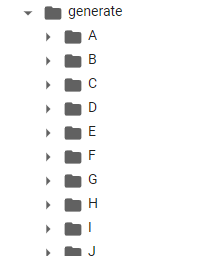

- Cek jumlah file di folder ./generate/A

In [34]:
!ls generate/A | wc -l

250


<BarContainer object of 26 artists>

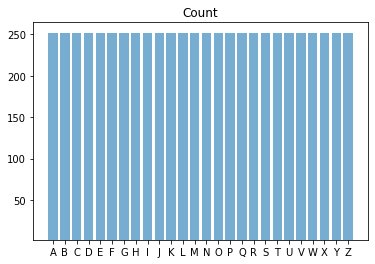

In [35]:
from string import ascii_uppercase

alphabets = [az for az in ascii_uppercase]
counts = [sum(os.path.isfile(os.path.join('./generate/'+az, f)) for f in os.listdir('./generate/'+az)) for az in ascii_uppercase]

plt.title('Count')
plt.bar(alphabets, counts, alpha=0.6, bottom=2, linewidth=2)

### Split dataset into data train, val, and testing

1. copy and split menggunakan library `split-folders`

In [24]:
splitfolders.ratio("generate", output="output",
    seed=1337, ratio=(.6, .2, .2), group_prefix=None, move=False)

Copying files: 6500 files [00:01, 4009.91 files/s]


- seed just random parameter [link](https://stackoverflow.com/questions/67597367/what-is-seed-for-in-splitting-test-val-data-in-python-and-how-to-come-up-with)

- splitfolders.ratio(source_dir, target_dir

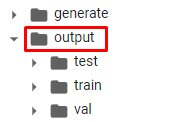

2. Define data training dan data testing variabel
  - mengecilkan lagi size image dari 256 -> 128
  - mengubah color image dari rgb -> grayscale

In [27]:
datagen = ImageDataGenerator(rescale=1./255)

train_set = datagen.flow_from_directory('/content/output/train/', 
                                        class_mode='binary', 
                                        target_size = (128, 128), 
                                        batch_size=64, 
                                        color_mode='grayscale')

val_set = datagen.flow_from_directory('/content/output/val/', 
                                      class_mode='binary', 
                                      target_size = (128, 128), 
                                      batch_size=64, 
                                      color_mode='grayscale')

test_set = datagen.flow_from_directory('/content/output/test/', 
                                        class_mode='binary', 
                                        target_size = (128, 128), 
                                        batch_size=64, 
                                        shuffle=False,
                                        color_mode='grayscale')

Found 3900 images belonging to 26 classes.
Found 1300 images belonging to 26 classes.
Found 1300 images belonging to 26 classes.


3. cek jumlah dataset

<BarContainer object of 26 artists>

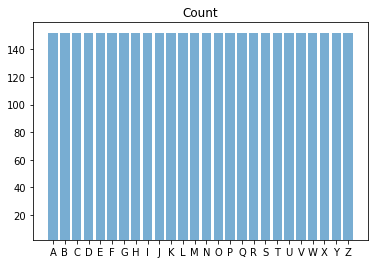

In [47]:
from string import ascii_uppercase

alphabets = [az for az in ascii_uppercase]
counts = [sum(os.path.isfile(os.path.join('./output/train/'+az, f)) for f in os.listdir('./output/train/'+az)) for az in ascii_uppercase]

plt.title('Count')
plt.bar(alphabets, counts, alpha=0.6, bottom=2, linewidth=2)

<BarContainer object of 26 artists>

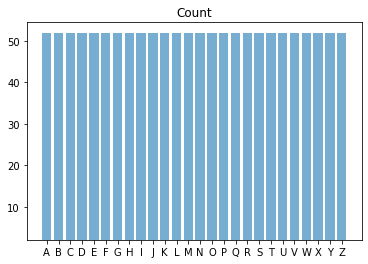

In [48]:
from string import ascii_uppercase

alphabets = [az for az in ascii_uppercase]
counts = [sum(os.path.isfile(os.path.join('./output/test/'+az, f)) for f in os.listdir('./output/test/'+az)) for az in ascii_uppercase]

plt.title('Count')
plt.bar(alphabets, counts, alpha=0.6, bottom=2, linewidth=2)

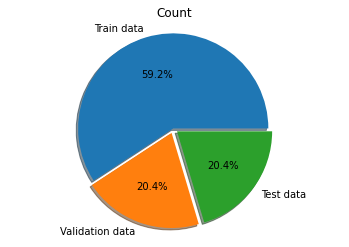

In [30]:
labels = ['Train data', 'Validation data', 'Test data']
values = [len(train_set), len(val_set), len(test_set)]

plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, explode=(0, 0.05, 0.05))
plt.axis('equal')
plt.title('Count')
plt.show()

- ref pie [link](https://www.w3schools.com/python/matplotlib_pie_charts.asp)

## Modeling 2

1. Design arsitektur model

In [19]:
def custom_model():

    classifier = Sequential()

    # 1st CNN Layer
    classifier.add(Conv2D(16, (3, 3), input_shape = (128, 128, 1), activation = 'relu', padding="same"))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))

    # 2nd CNN Layer
    classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding="same"))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))

    # 3rd CNN Layer
    classifier.add(Conv2D(48, (3, 3), activation = 'relu', padding="same"))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))

    # 4th CNN Layer
    classifier.add(Conv2D(64, (3, 3), activation = 'relu', padding="same"))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))

    classifier.add(Flatten())
    
    # 1st Fully Connected Layer
    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dropout(0.5))

    # output layer
    classifier.add(Dense(units = 26, activation = 'softmax'))

    classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    return classifier

In [20]:
model = custom_model() 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 48)        13872     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 48)       0

2. Define callback

In [11]:
callback = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True)

3. Train model
  
  - epoch : 50
  - using train_set dan val_set
    - source training : /content/output/train/
    - source validation : /content/output/val/

In [ ]:
history = classifier.fit(train_set, 
                         steps_per_epoch=len(train_set), 
                         epochs = 50,
                         verbose=1,
                         validation_data=val_set, 
                         validation_steps=len(val_set),
                         callbacks=[callback]
                         )

Epoch 1/50
61/61 [==============================] - 32s 297ms/step - loss: 3.2624 - accuracy: 0.0372 - val_loss: 3.2531 - val_accuracy: 0.0392
Epoch 2/50
61/61 [==============================] - 19s 305ms/step - loss: 3.1158 - accuracy: 0.0928 - val_loss: 2.4812 - val_accuracy: 0.2654
Epoch 3/50
61/61 [==============================] - 18s 300ms/step - loss: 2.2768 - accuracy: 0.2795 - val_loss: 1.4765 - val_accuracy: 0.5885
Epoch 4/50
61/61 [==============================] - 18s 288ms/step - loss: 1.6413 - accuracy: 0.4551 - val_loss: 0.8572 - val_accuracy: 0.7946
Epoch 5/50
61/61 [==============================] - 19s 306ms/step - loss: 1.1812 - accuracy: 0.5959 - val_loss: 0.4894 - val_accuracy: 0.8569
Epoch 6/50
61/61 [==============================] - 18s 289ms/step - loss: 0.9261 - accuracy: 0.6849 - val_loss: 0.3673 - val_accuracy: 0.9015
Epoch 7/50
61/61 [==============================] - 18s 289ms/step - loss: 0.7417 - accuracy: 0.7382 - val_loss: 0.2195 - val_accuracy: 0.9523

4. show accuracy history diagram 

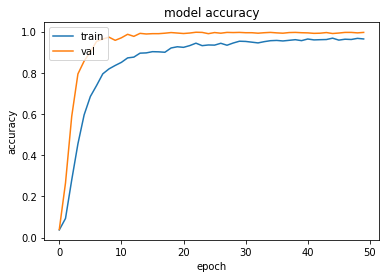

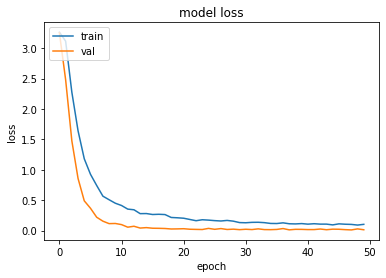

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

5. Save model

In [ ]:
model.save('2_model_bisindo_3.h5')

## Model Evaluated

In [33]:
def modelEvaluate(varModel,train_set,val_set) :
  train_loss, train_acc = varModel.evaluate(train_set)
  test_loss, test_acc   = varModel.evaluate(val_set)
  print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

0. Load model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [31]:
# It can be used to reconstruct the model identically.
model = keras.models.load_model("/content/drive/MyDrive/ML/2_model_bisindo_3.h5")

1. define new image generator
  - shuffle : false (buat false agar confusion matrix tidak bingung)
  - sumber data : /content/output/test/

In [34]:
modelEvaluate(model,train_set,val_set)

21/21 [==============================] - 4s 199ms/step - loss: 0.0135 - accuracy: 0.9962
final train accuracy = 100.00 , validation accuracy = 99.62


### Confusion Matrix 

In [38]:
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)
predictions = model.predict(test_set, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

In [39]:
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())

In [ ]:
confusion_matrix(true_classes,predicted_classes)

In [40]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        50
           B       0.98      1.00      0.99        50
           C       0.98      1.00      0.99        50
           D       1.00      0.94      0.97        50
           E       1.00      1.00      1.00        50
           F       1.00      0.98      0.99        50
           G       1.00      1.00      1.00        50
           H       0.98      1.00      0.99        50
           I       1.00      0.98      0.99        50
           J       1.00      1.00      1.00        50
           K       1.00      0.98      0.99        50
           L       1.00      0.98      0.99        50
           M       1.00      1.00      1.00        50
           N       0.98      1.00      0.99        50
           O       0.98      1.00      0.99        50
           P       0.98      1.00      0.99        50
           Q       0.98      0.98      0.98        50
           R       1.00    

### Confusion Matrix Grafik

In [42]:
# show the confusion matrix of our predictions

def plot_confusion2(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, normalize=True ):
    
    if normalize :
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
   
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2. if normalize else cm.max() / 1.5
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [43]:
def f1score_conf(model,val_gen):

  # y_pred = [np.argmax(probas) for probas in predictions]
  # y_test = validation_generator_4.classes
  class_names = val_gen.class_indices.keys()

  test_generator =  val_gen
  y_true = test_generator.classes
  y_hat =  model.predict(test_generator)
  y_hat = tf.argmax(y_hat, axis = 1).numpy()
  f1 = f1_score(y_true, y_hat, average='micro')
  print('f1 score {}'.format(f1))
    
  cnf_matrix = confusion_matrix(y_true = y_true, y_pred = y_hat) 

  plot_confusion2(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
  plot_confusion2(cnf_matrix, classes=class_names, title='confusion matrix', normalize=False)

f1 score 0.9907692307692307


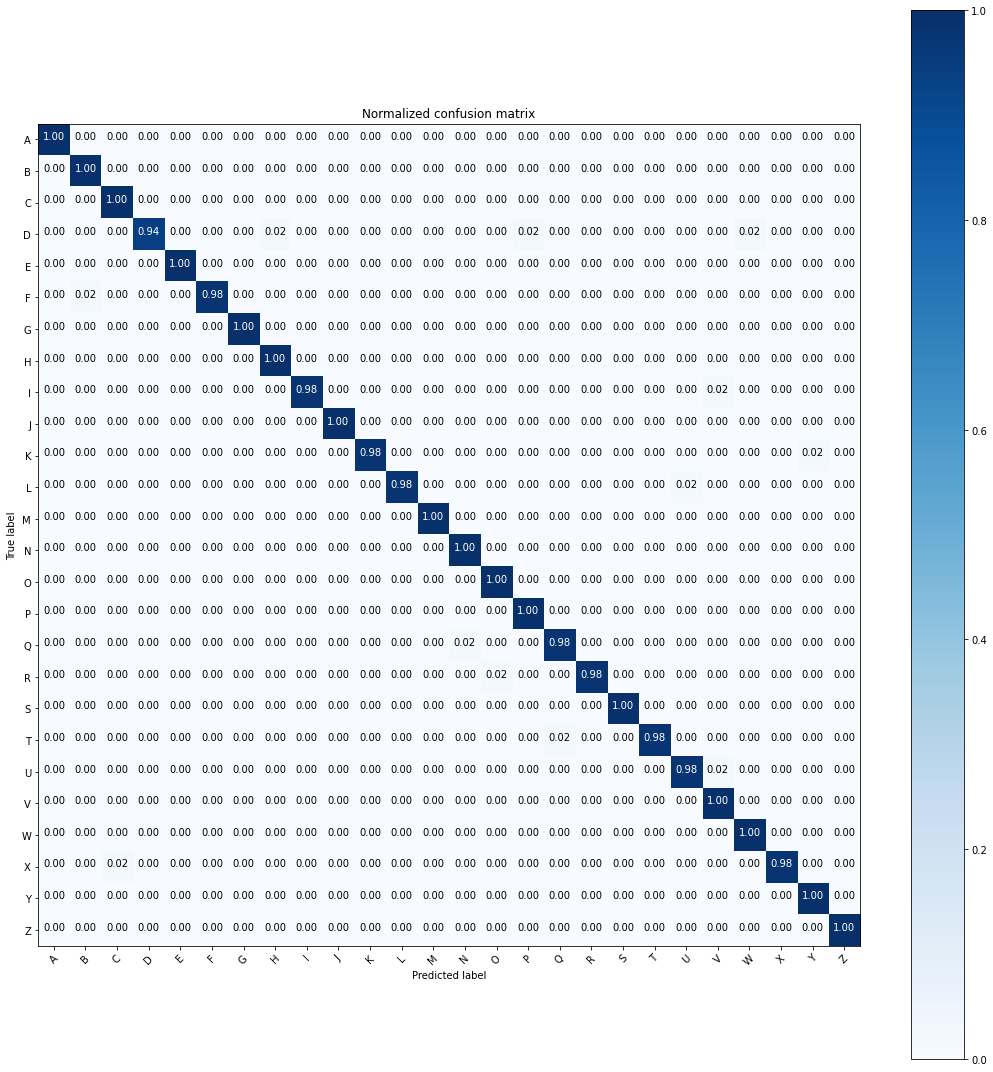

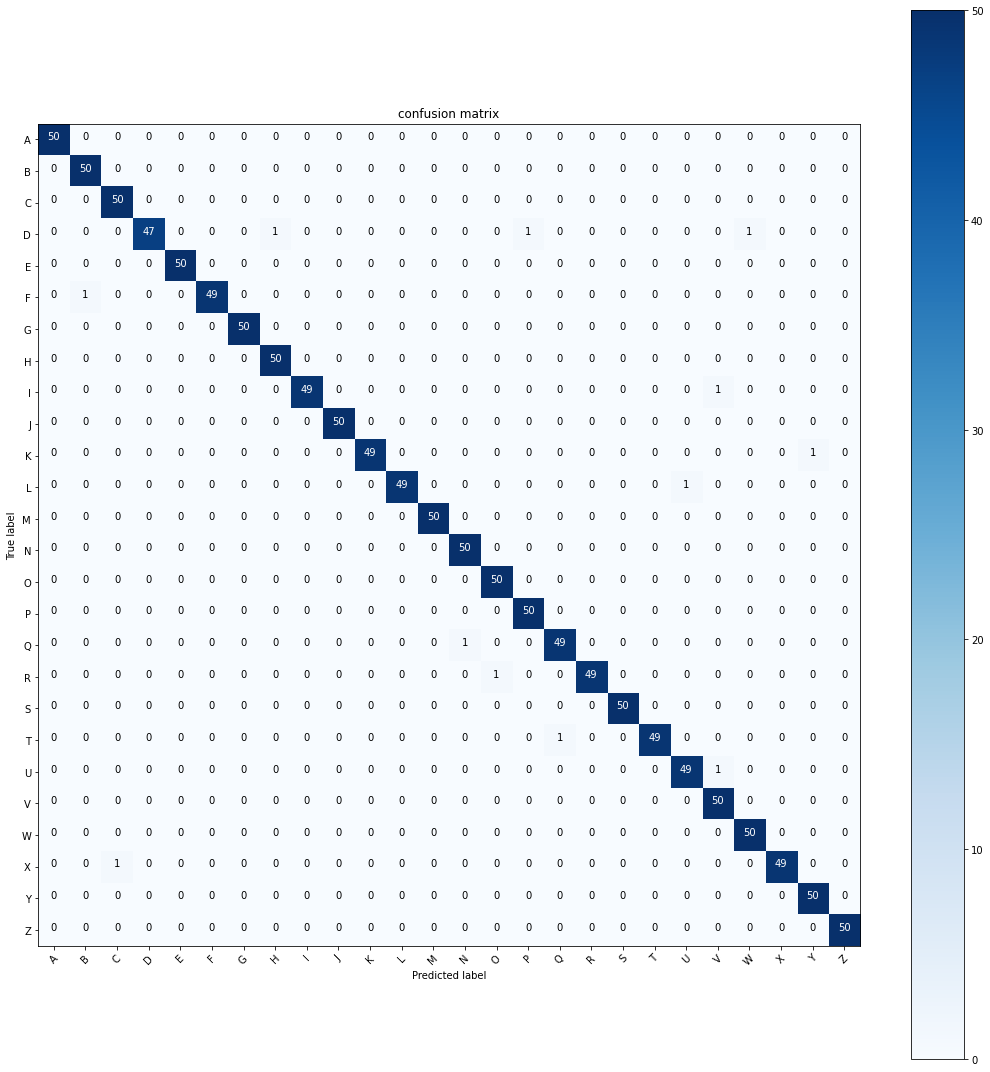

In [46]:
f1score_conf(model,test_set)

## Deployment

In [36]:
labels = ['A','B','C','D','E','F',
          'G','H','I','J','K','L',
          'M','N','O','P','Q','R',
          'S','T','U','V','W','X',
          'Y','Z']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [37]:
# It can be used to reconstruct the model identically.
model = keras.models.load_model("/content/drive/MyDrive/ML/2_model_bisindo_3.h5")

### Ways 1
- image classification from local image

In [43]:
def predict(img):
    img = cv2.imread(img)
    img = cv2.resize(img,(128,128))

    x = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x = x.astype("float") / 255.0
    x = img_to_array(x)
    x = np.expand_dims(x, axis=0)

    result = model.predict(x)
    label = labels[np.argmax(result[0])]

    imgplot = plt.imshow(img)
    print("Label Predicted : ",label)

Label Predicted :  B


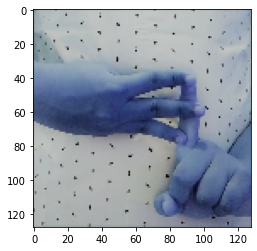

In [44]:
img = './Citra BISINDO/B/body dot (1).jpg'
predict(img)

### Ways 2 
- Real Time Classification using video stream 

In [45]:
# Import Libaraires 

from IPython.display import display, Javascript, Image,clear_output
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [46]:
# Initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [47]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [48]:
# Function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# Function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [55]:
# Defining function to detect face
def face_detect():
  import cv2
  from PIL import Image
  import numpy as np
  import os
  from keras.models import load_model
  from time import sleep
  from keras.preprocessing.image import img_to_array
  from keras.preprocessing import image
# start streaming video from webcam
  video_stream()
# label for video
  label_html = 'Capturing...'
# initialze bounding box to empty
  bbox = ''
  count = 0
  face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') # Face Detection

  classifier =load_model('/content/drive/MyDrive/ML/2_model_bisindo_3.h5')  #Load model
  emotion_labels = labels

  while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
      break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # gray = img

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    
    roi_gray = cv2.resize(gray,(128,128),interpolation=cv2.INTER_AREA)  ##Face Cropping for prediction

    roi = img_to_array(roi_gray)/255. 

    roi = np.expand_dims(roi,axis=0) ## reshaping the cropped face image for prediction 

    prediction = classifier.predict(roi)[0]   #Prediction

    label =emotion_labels[prediction.argmax()]

    cv2.putText(bbox_array,label,(30,80),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

    # test image yg tercapture
    # imgplot = plt.imshow(img)

In [ ]:
#Finally detecting the face with live webcam
face_detect()

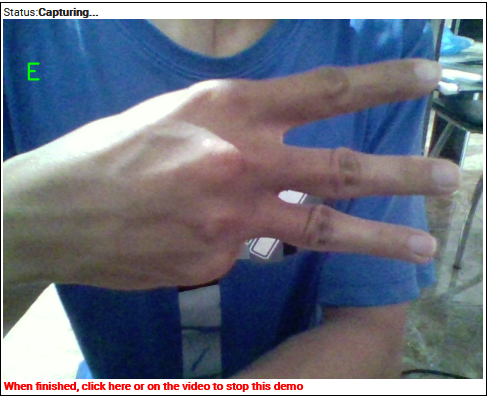

In [ ]:
## Kesimpulan